In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
import statsmodels.api as sm
import os, sys
import warnings
warnings.filterwarnings('ignore')
# import my own modules
path = os.path.abspath(os.path.join('..'))
if path not in sys.path:
    sys.path.append(path)

from Research.signals import lookback_zscore, zscore_signal, zscore_sizing, generate_mtm_pnl, generate_pnl_index, generate_exposures 
from Preprocessing.labeling import get_t1, _apply_pt_sl
from Preprocessing.sampling import get_events_avg_uniqueness, _get_num_concurrent_events, _get_average_uniqueness


# Initial exploration

index counts: (sec_0, 12601)    101
(sec_4, 12601)    101
(sec_5, 12601)    101
(sec_3, 12601)     96
(sec_6, 12601)     69
(sec_3, 5366)       1
(sec_8, 6307)       1
(sec_0, 5135)       1
(sec_6, 5365)       1
(sec_8, 4866)       1
dtype: int64
anything less than 0? id
sec_0    False
sec_3    False
sec_4    False
sec_5    False
sec_6     True
sec_7    False
sec_8    False
dtype: bool
id      sec_0   sec_3   sec_4   sec_5  sec_6  sec_7    sec_8
dtidx                                                       
5378   0.6013  2.6274  3.2473  4.3507 -0.010  16.70  1356.62
5380   0.5734  2.5366  3.1499  4.2556 -0.010  18.20  1335.10
5418   0.4614  2.3884  3.1118  4.3766 -0.020  17.27  1307.41
5419   0.4576  2.4961  3.1600  4.3710 -0.010  16.52  1320.64
5422   0.4226  2.4214  3.1080  4.3625 -0.020  16.34  1339.22
5425   0.3551  2.2108  2.9189  4.2083 -0.010  18.39  1319.49
5899   0.2931  1.4852  2.1110  3.2712 -0.050  14.53  1654.41
6001   0.3068  1.8888  2.5016  3.5947 -0.010  13.42  1746.38
6

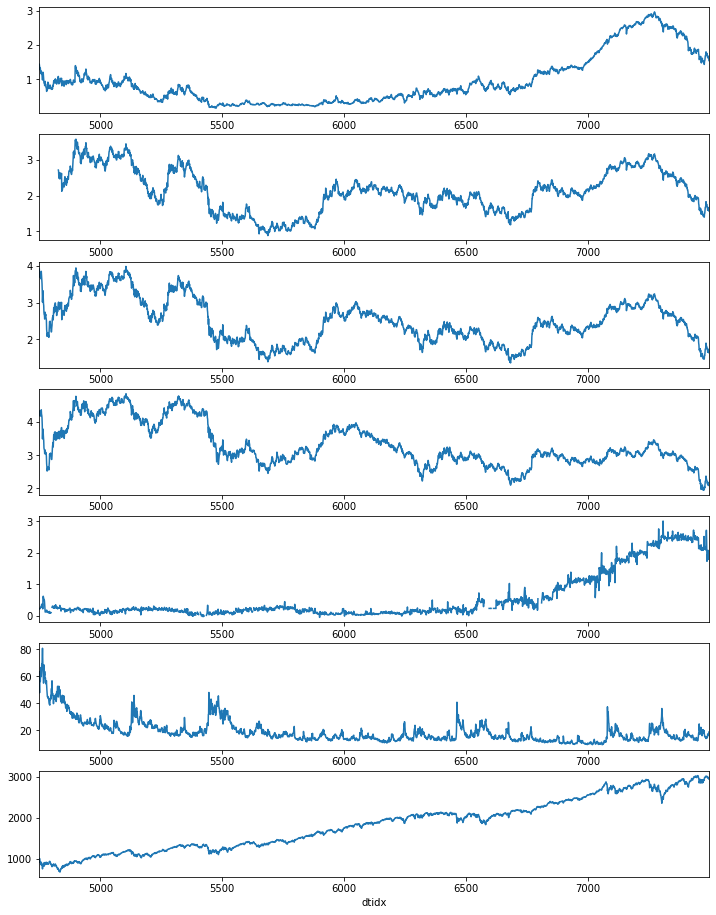

In [5]:
events = pd.read_csv('C:/Users/Brendan/Documents/PIMCO/AlgoTradingTest/events.csv')
px_raw = pd.read_csv('C:/Users/Brendan/Documents/PIMCO/AlgoTradingTest/px.csv')

#scrub
px = px_raw.set_index(['id','dtidx'])
print('index counts:', px.index.value_counts().head(10))
px = px[~px.index.duplicated(keep='first')] #drop duplicates
px = px.unstack(level=0)
px = px[px.index!=12601] #these indices come much later than others and appear to be noise

#take a look
px.columns = px.columns.droplevel(0)
print('anything less than 0?', px[px<0].any()) #log returns will fail
print(px[px['sec_6']<0])

print('dimensions:', px.shape)
fig, ax = plt.subplots(figsize=(12,16), nrows=px.shape[1])
for i, col in enumerate(px.columns):
    px[col].plot(ax=ax[i])
plt.show()


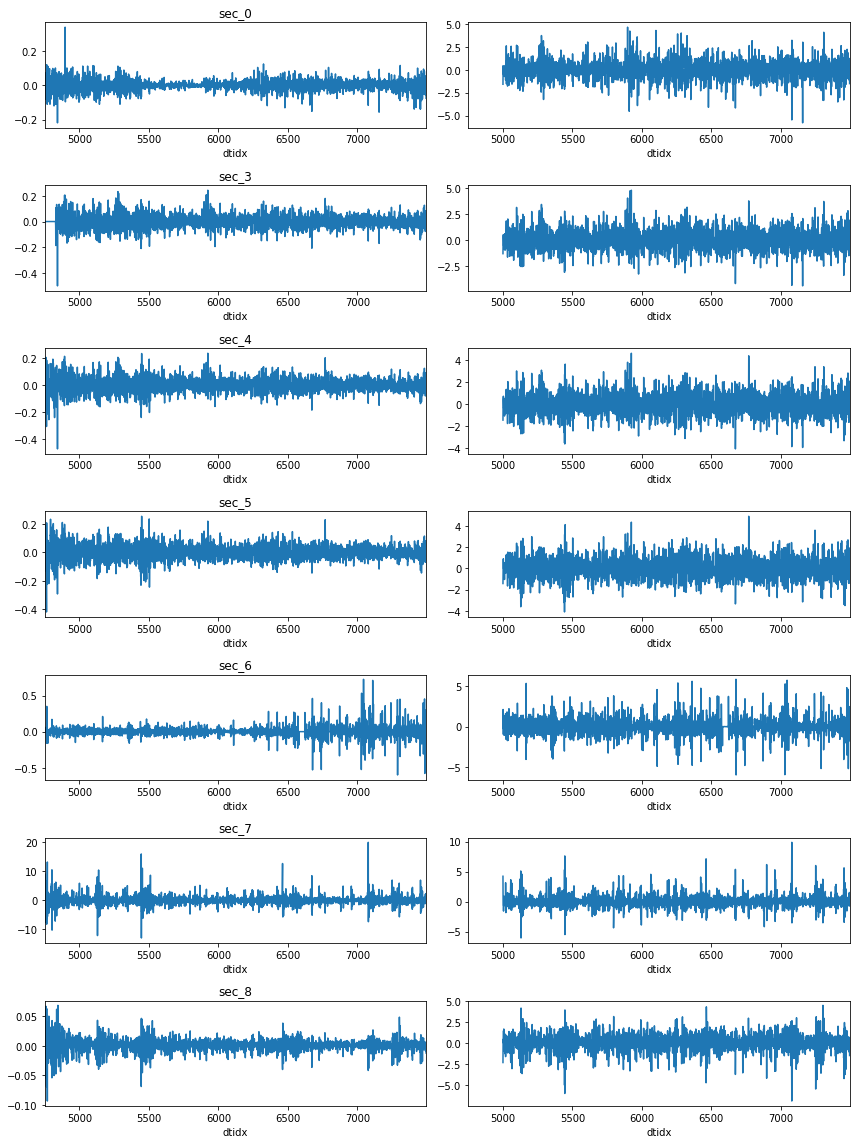

In [6]:
#returns
#sec_0-sec_5 are rates, sec6 is a mmkt rate that trades below 0, sec7 is vix, look at first diff of these
#sec8 is sp500, look at returns
rets = px.copy()
rets = rets.fillna(method='ffill')
rets['sec_8'] = rets['sec_8'].apply(np.log)
rets = rets.diff(1).fillna(0)

#standardize on 6m rolling basis
std_rets = rets.subtract(rets.rolling(126).mean())
std_rets = std_rets.divide(std_rets.rolling(126).std())

fig, ax = plt.subplots(figsize=(12,16), nrows=rets.shape[1], ncols=2)
for i, col in enumerate(rets.columns):
    ax[i][0].set_title(col)
    rets[col].plot(ax=ax[i][0])
    std_rets[col].plot(ax=ax[i][1])
fig.tight_layout()
plt.show()



# PCA

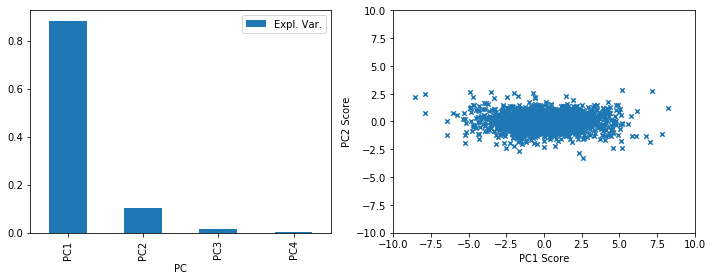

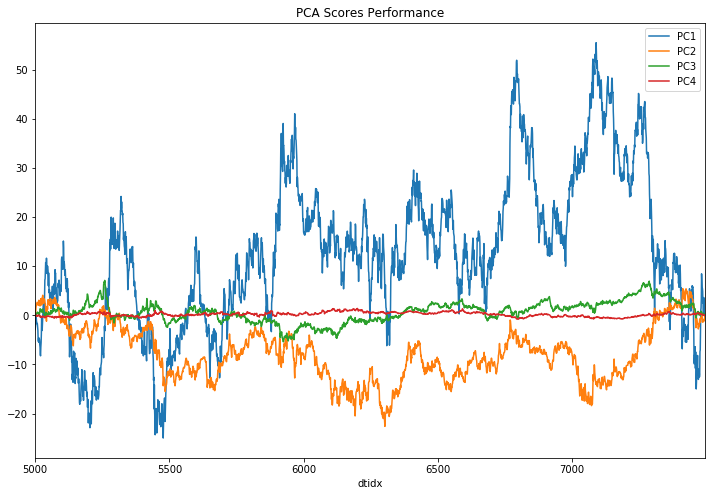

Loadings Matrix:


,sec_0,sec_3,sec_4,sec_5
PC1,0.464,0.521,0.522,0.490
PC2,-0.812,0.004,0.203,0.548
PC3,0.355,-0.649,-0.253,0.624
PC4,-0.015,0.554,-0.789,0.266


In [45]:
#pca
cols = ['sec_0','sec_3','sec_4','sec_5']
prepca_data = std_rets[cols].dropna(how='any')
pca = PCA()
pca.fit(prepca_data)
pc_cols = ['PC'+str(i+1) for i in np.arange(pca.n_components_)]

exp_var = pd.DataFrame(zip(pca.explained_variance_ratio_, pc_cols), 
                       columns=['Expl. Var.','PC'])

# flip signs to induce 'standard' interpretation of rates pca
scores = pd.DataFrame(-pca.fit_transform(prepca_data), index=prepca_data.index, columns=pc_cols)
loadings = pd.DataFrame(-pca.components_, index=['PC'+str(i) for i in np.arange(1,pca.n_components_+1)], columns=cols)
integrated_scores = scores.cumsum()


fig0, ax0 = plt.subplots(figsize=(10,4),ncols=2)
exp_var.plot.bar(x='PC', y='Expl. Var.', ax=ax0[0])
ax0[1].scatter(scores['PC1'].values, scores['PC2'].values, s=20, marker="x")
ax0[1].set_xlim(-10,10)
ax0[1].set_ylim(-10,10)
ax0[1].set_xlabel('PC1 Score')
ax0[1].set_ylabel('PC2 Score')
fig0.tight_layout()

fig, ax = plt.subplots(figsize=(12,8))
integrated_scores.plot(ax=ax)
ax.set_title('PCA Scores Performance')
plt.show()
print('Loadings Matrix:') 
loadings.round(3)

## Momentum Analysis

In [37]:
def gen_subseq_returns(px, signal, max_len=30):
    """
        Generate ('single contract') returns subsequent to signal firing to evaluate predictiveness
    
    :param px: (pd.Series) series of prices
    :param signal: (pd.Series) series of entry signals (-1,0,1)
    :param max_len: (int) max index lookahead
    
    :return: (pd.DataFrame) returns up to max_len (cols), per signal fire (index)
    """
    signal = signal[signal!=0]
    sub_rets = pd.DataFrame(index=signal.index, columns=np.arange(max_len+1))
    
    for t, sig in signal.iteritems():
        t1_idx = min(px.index.searchsorted(t)+max_len, len(px.index)-1) #end of analysis period
        t1 = px.index[t1_idx]
        px0 = px.loc[t]
        sub_px = px.loc[t:t1].values
        sub_ret_np = np.array(sig*(sub_px-px0))
        if (len(sub_px)<max_len+1):
            sub_ret_np = np.hstack((sub_ret_np,sub_ret_np[-1]*np.ones(max_len+1-len(sub_px))))
        sub_rets.loc[t,:] = sub_ret_np
    
    if (sub_rets.shape[0]!=len(signal)): 
        raise ValueError('Num. of return subsets {0} not equal to num. signals given {1}!'.format(sub_rets.shape[0], 
                                                                                                  len(signal)))
    return sub_rets
    

def analyze_sub_rets(sub_rets, label, ax=None, subseq_days=[5,20,40], z_threshold=0):
    """
        Generate basic stats summary and plot avg subsequent return series
    
    :param sub_rets: (pd.DataFrame) subsequent returns (columns=days subseq.) per entry signal index
    :return: (pd.Series) summary statistics (and plot avg subsq return series)
    """
    
    avg_sub_rets = sub_rets.mean(axis=0)
    std_sub_rets = sub_rets.std(axis=0)
    if ax is None:
        fig, ax = plt.subplots(figsize=(8,6), nrows=2, dpi=300)
    label_legend = str(label)+'-d lookback'
    avg_sub_rets.plot(ax=ax[0],label=label_legend)
    ax[0].set_title('Subsequent Return Avgs: '+str(np.round(z_threshold,2))+'-sigma Threshold')
    ann_ir = avg_sub_rets.divide(std_sub_rets)*np.sqrt(250/sub_rets.columns.values)
    ann_ir.plot(ax=ax[1], label=label_legend)
    ax[1].set_title('Subsequent Return Ann. IR*')
    
    # maybe use framework more in-depth
    stats = ['Mean', 'Std Dev', 'Ann. IR', 'Min','Max', 'Max DD', 'Num Obs', 'Hit Ratio']
    stats_arr = []
    for sp in subseq_days:
        sr = sub_rets.loc[:, sp]
        mean = sr.mean()
        stdev = sr.std()
        ann_ir = mean/stdev*np.sqrt(250/sp)
        mn = sr.min()
        mx = sr.max()
        max_dd = np.min(sub_rets.loc[:, np.arange(sp+1)].values)
        num_obs = len(sr)
        hit_ratio = len(sr[sr>0])/num_obs
        stats_srs = pd.Series([mean, stdev, ann_ir, mn, mx, max_dd, num_obs, hit_ratio], index=stats, name=sp)
        stats_arr.append(stats_srs)
    summary_df = pd.concat(stats_arr, axis=1).round(4)
    return summary_df


def gen_mom_signals(px, z_threshold=1., lookbacks=[1,3,5,10,30], zscore_lookback=25, signal_type='Momentum', center=False):
    """
        Generate series of signals (-1,0,1: short,none,long) based on zscore lookback returns
    
    :param px: (pd.Series) close prices
    :param lookbacks: (1d array) px change lookback timeframe array
    :param zscore_lookback: (int) rolling window length
    :param signal_type: (string) in ('Momentum', 'Reversion')
    :return: (pd.DataFrame) signals vector per lookback timeframe 
    """
    zscore_arr = []
    for lookback in lookbacks:
        zscore = lookback_zscore(px, lookback, zscore_lookback, log_ret=False, center=center)
        zscore_arr.append(zscore)
    # rolling (zscore_lookback) window zscores
    zscores = pd.concat(zscore_arr, axis=1)
    zscores.columns = lookbacks
    # dataframe of signals per lookback freq
    # uses function zscore_signal from my personal library also attached to submission
    signals = zscore_signal(zscores, z_threshold, signal_type)
    signals.columns = lookbacks
    
    return signals, zscores


def uniq_weighted_returns(px, signal, v, apply_side=False):
    """
        Generate return series of a simple indicator strategy adjusting for common return components
        (i.e. overlapping subsequent days from consecutive signal firing)
    :param px: (pd.Series) series of prices
    :param signal: (pd.Series) series of entry signals (-1,0,1)
    :param v: (int) end of signal in days (time stop-out)
    :return: uniqueness weighted v-period subsequent return series
    """
    signal = signal[signal!=0]
    t1 = get_t1(signal.index, px, vertbar=v).rename('t1')
    avg_uniq = get_events_avg_uniqueness(px, t1)
    
    wgt_rets = avg_uniq.join(signal.rename('side')).dropna()
    wgt_rets = wgt_rets.join(t1)
    wgt_rets['start_px'] = px.loc[wgt_rets.index].values
    wgt_rets['end_px'] = px.loc[wgt_rets.loc[:, 't1'].values].values
    wgt_rets['simple_ret'] = wgt_rets.loc[:, 'end_px']-wgt_rets.loc[:, 'start_px']
    wgt_rets['wgt_ret'] = wgt_rets.loc[:, 'simple_ret']*wgt_rets.loc[:, 'tw']
    if apply_side:
        wgt_rets.loc[:, 'wgt_ret'] = wgt_rets.loc[:, 'wgt_ret']*wgt_rets.loc[:, 'side']
    
    return wgt_rets


def get_pat_events(px, signal, v):
    """
        Generate single position series that averages active signals
    
    :param px: (pd.Series) series of prices
    :param signal: (pd.Series) series of entry signals (-1,0,1)
    :param v: (int) end of signal in days (time stop-out)
    :return: (pd.DataFrame) average signal frame, basic events srs
    """
    signal = signal[signal!=0]
    t1 = get_t1(signal.index, px, vertbar=v).rename('t1')
    events = t1.to_frame().merge(signal.rename('side'), how='left', left_index=True, right_index=True)
    
    # we want to weight each trade by the inverse of how many open trades there are over the holding period
    # this has the effect of keeping a live position equal to the average of each equally weighted signal
    num_concurrent = _get_num_concurrent_events(px.index, t1)
    events['size'] = _get_average_uniqueness(t1, num_concurrent)
    #will be our position time series
    out = pd.DataFrame(0, index=px.index, columns=['sum_position','count']) 
    
    for row in events.itertuples():
        out.loc[row.Index:row.t1, 'count'] += 1
        out.loc[row.Index:row.t1, 'sum_position'] += row.side
    
    out['position'] = out.loc[:, 'sum_position']/out.loc[:, 'count']
    return out, events


def generate_perf_summary(events, close_tr):
    """
    Function to generate CAGR, vol, sharpe, calmar, max drawdown, # trades, avg pnl per trade, hit ratio
    
    :input events: (pd.DataFrame) 'events' dataframe with t1, side, size, trgt
    :input close_tr: (pd.Series) total return series of underlying product
    :return: (pd.DataFrame) summary of pnl attributes
    """
    pnl = generate_mtm_pnl(events, close_tr, log_diff=False)
    pnl_index = generate_pnl_index(pnl)
    last_date = max(np.hstack((events['t1'].iloc[-1],pnl_index.index[-1])))
    years_live = (last_date-events.index[0])/252
    # since it's constant exposure, use simple average
    #cagr = np.power(pnl_index.iloc[-1]/pnl_index.iloc[0],1/years_live)-1.
    avg_ret = (pnl_index.iloc[-1]/pnl_index.iloc[0]-1)/years_live
    returns = pnl_index.diff(1).dropna()
    vol = returns.std()
    # assumes daily close data
    annualized_vol = vol*np.sqrt(252)
    sharpe = avg_ret/annualized_vol
    drawdown_pnl = pnl_index.subtract(pnl_index.expanding(0).max())
    max_dd = np.min(drawdown_pnl)
    calmar = -avg_ret/max_dd
    num_trades = events[abs(events['side'])>0].shape[0]
    avg_pnl = pnl.mean()
    #hit_ratio = events[events['side']==1].shape[0]/num_trades
    
    summary = pd.Series([avg_ret,annualized_vol,sharpe,calmar, max_dd, num_trades, avg_pnl], 
                       index=['Ann. Ret.','Ann. Vol.','IR','Calmar','Max Drawdown','# Trades','Avg. Daily PnL'])
    return summary, pnl_index

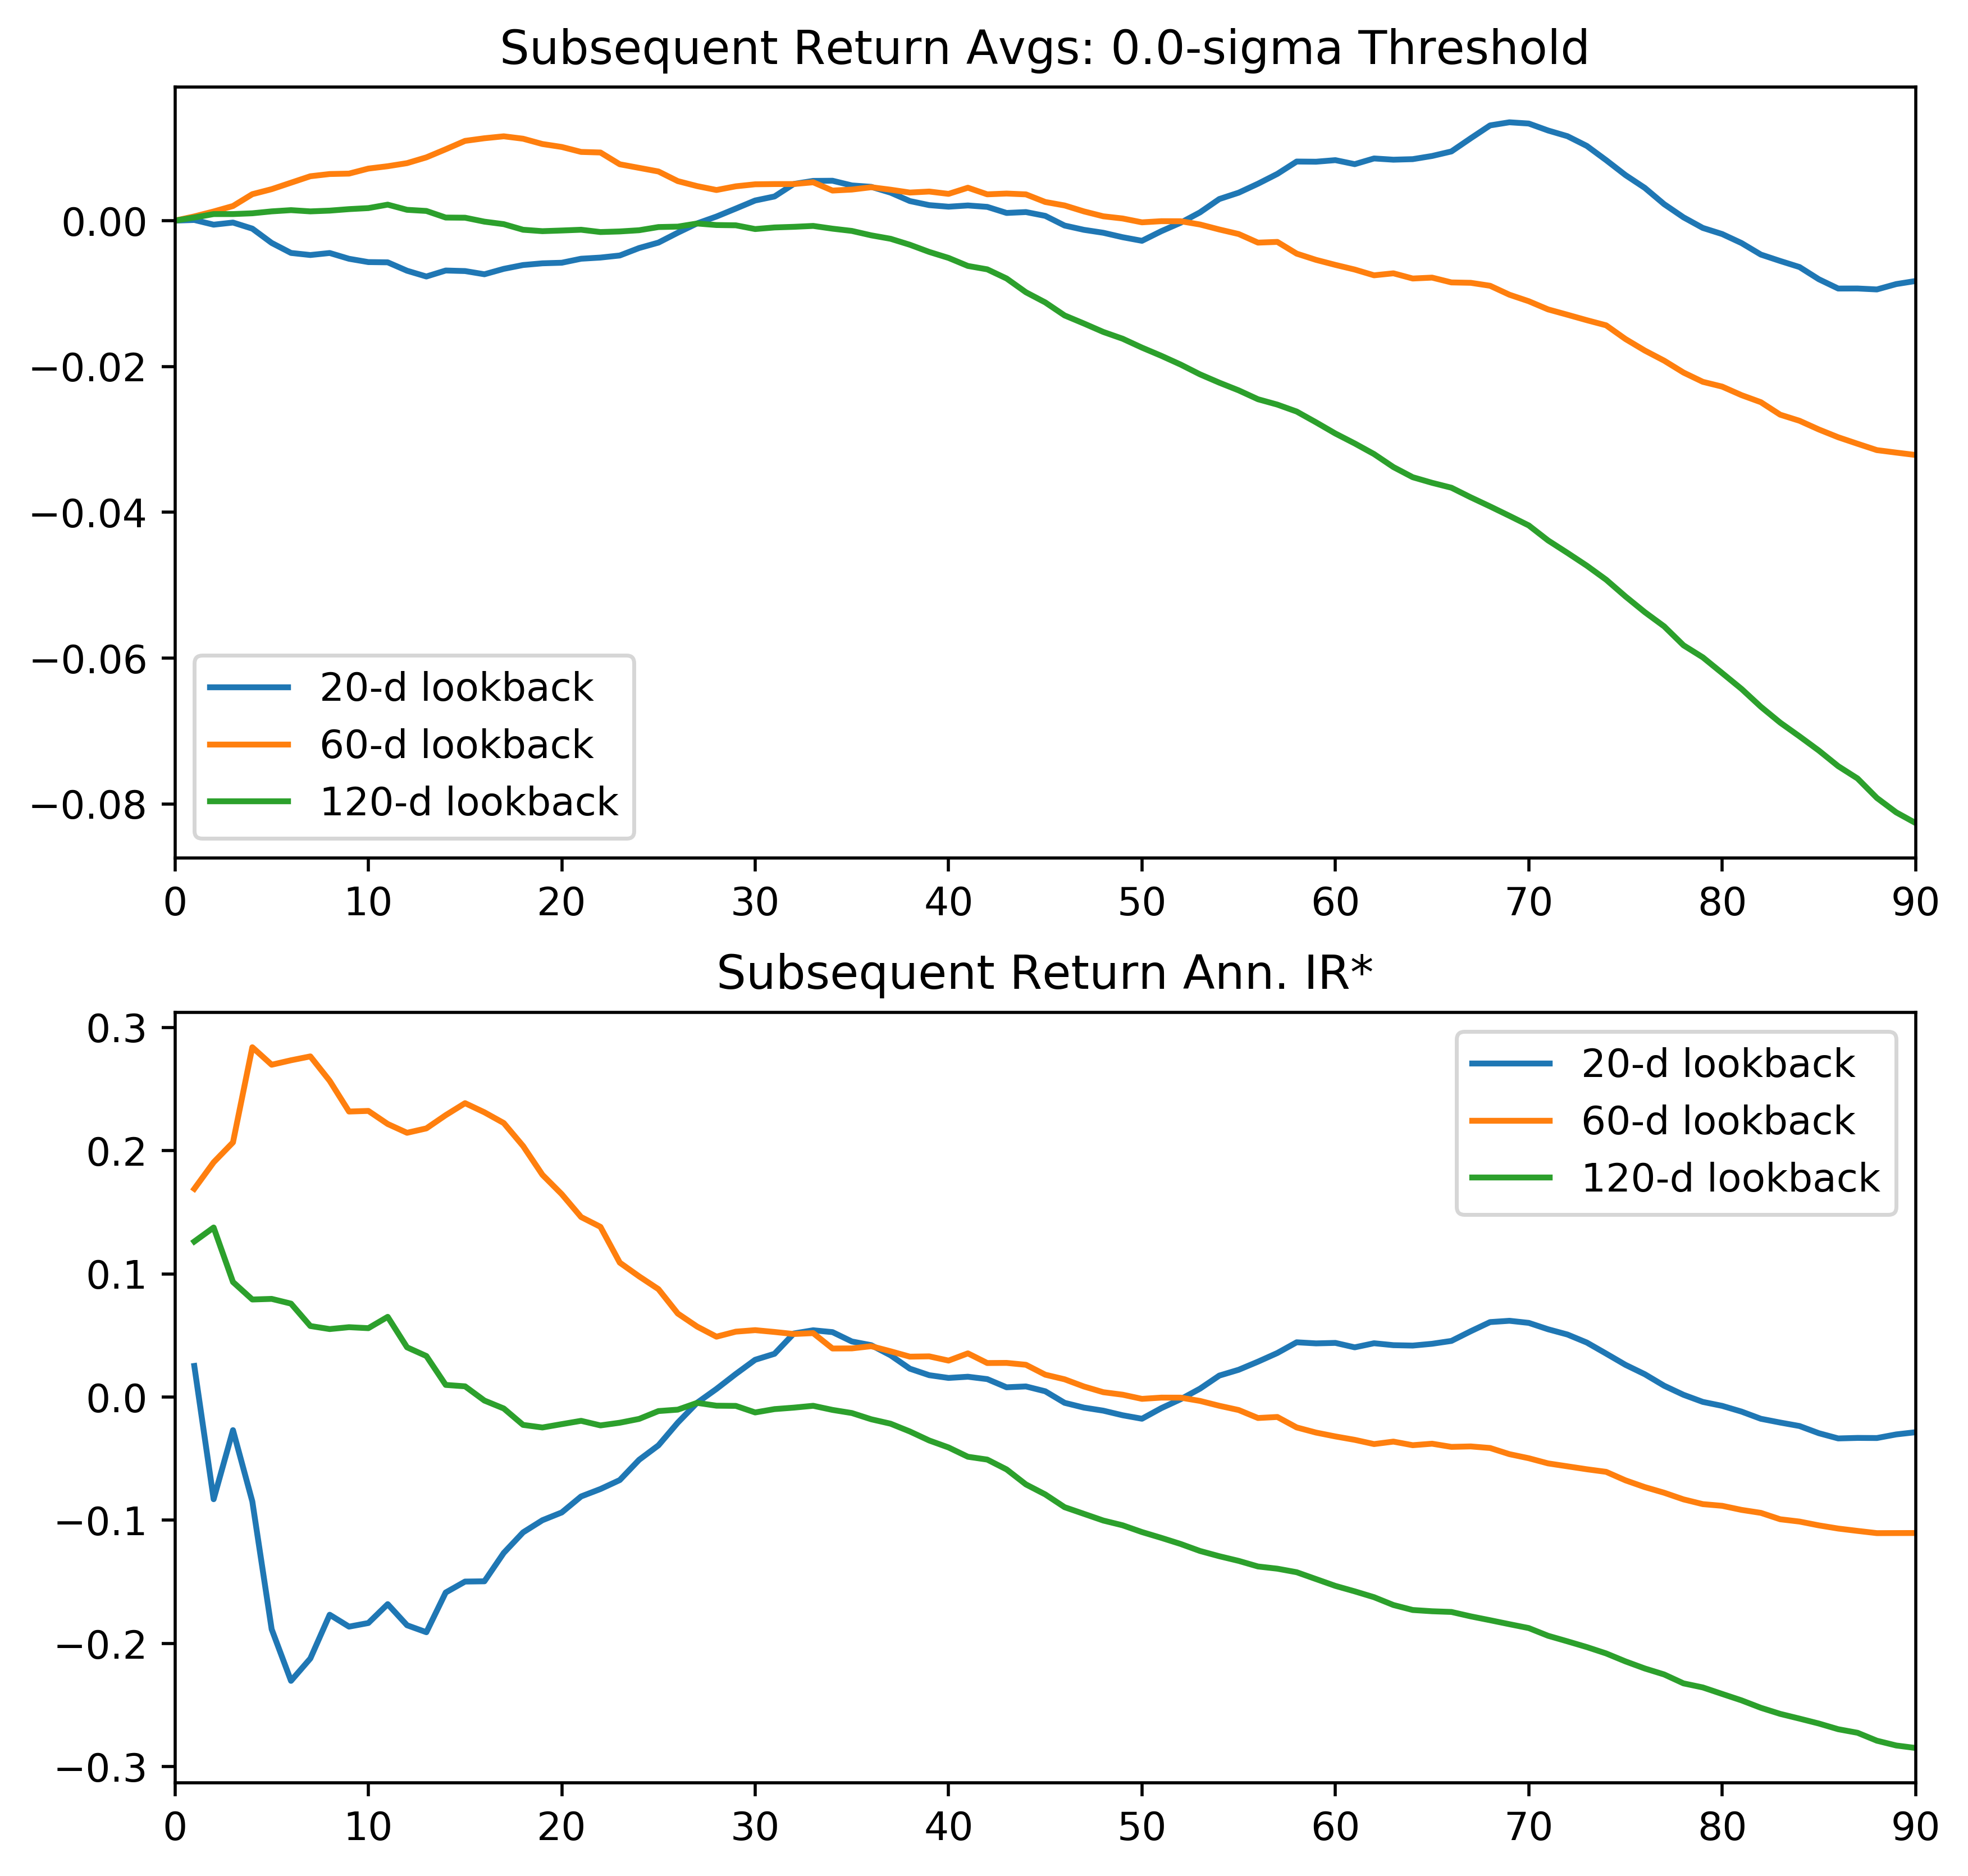

lookback          20                               60                         \
fwd period         5          20         40         5          20         40   
Mean          -0.0031    -0.0058     0.0019     0.0043     0.0101     0.0037   
Std Dev        0.1148     0.2180     0.3078     0.1131     0.2170     0.3103   
Ann. IR       -0.1884    -0.0937     0.0155     0.2697     0.1646     0.0296   
Min           -0.3706    -0.9512    -1.0953    -0.4091    -0.6351    -1.0566   
Max            0.5426     0.7763     1.2623     0.5426     0.9512     1.2623   
Max DD        -0.4110    -0.9512    -1.1200    -0.4091    -0.6437    -1.0566   
Num Obs     2059.0000  2059.0000  2059.0000  2017.0000  2017.0000  2017.0000   
Hit Ratio      0.4638     0.4774     0.4847     0.4844     0.5072     0.4953   

lookback          120                        
fwd period         5          20         40  
Mean           0.0013    -0.0014    -0.0051  
Std Dev        0.1126     0.2178     0.3125  
Ann. IR        0.0796    -0.0220    -0.0409  
Min           -0.4353    -0.6918    -1.0566  
Max            0.5426     0.9512     1.2623  
Max DD        -0.4353    -0.7589    -1.0566  
Num Obs     1959.0000  1959.0000  1959.0000  
Hit Ratio      0.4916     0.4814     0.4834

In [38]:
in_sample_end = px.index[-int(px.shape[0]/5)] #dtidx of when in-sample period ends
lookbacks = [20,60,120] #return frequencies
z_threshold = 0.0 #zscore threshold for signal generation, 0 for simplicity otherwise we have complexities arising from overlaps
zscore_lookback = 120 #rolling window size to generate zscores
max_len = 90 #maximum subsequent return length
series_name = 'sec_4'
srs = px.loc[:in_sample_end, series_name] #in-sample series to analyze

def plot_subsq_rets(srs, lookbacks, z_threshold, zscore_lookback, max_len):
    """ Plot average returns and annualized IR for returns after a momentum signal trigger """
    signals, zscores = gen_mom_signals(srs, z_threshold=z_threshold, lookbacks=lookbacks, zscore_lookback=zscore_lookback)

    fig, ax = plt.subplots(figsize=(8,8), nrows=2, dpi=500)
    stats_arr = []
    for l in lookbacks:
        sub_rets = gen_subseq_returns(srs, signals.loc[:,l], max_len=90)
        summary_stats = analyze_sub_rets(sub_rets, label=l, ax=ax, subseq_days=[5,20,40], z_threshold=z_threshold)
        stats_arr.append(summary_stats)
    for a in ax:
        a.legend()
    plt.show()
    stats_df = pd.concat(stats_arr, axis=1, keys=lookbacks, names=['lookback','fwd period'])
    return stats_df

plot_subsq_rets(srs, lookbacks, z_threshold, zscore_lookback, max_len)

#### *Since these forward periods are consistently overlapping, we are overstating the unique observations we have in this analysis
#### Next step is to look at non-overlapping regressions, and take averages over the potential starting points
#### We normalize our returns by trailing vol in order to mitigate large returns exerting undue influence on the estimated parameters

In [39]:
ret_length = 90
def gen_regression_details(srs, ret_length, zscore_lookback=120, z_threshold=0.0):
    """
        Generate betas and t-statistics on regressions (r_t,t+x regressed against r_t-x,t),
        averaged over potential start points t=0:x
    """
    diff_srs = srs.diff(ret_length).dropna()
    norm_diff = diff_srs.divide(diff_srs.rolling(zscore_lookback).std()).dropna().to_frame()
    norm_diff['fwd'] = norm_diff.shift(-ret_length)
    norm_diff = norm_diff.dropna(how='any')
    betas, tstats = [], []

    # we take averages over each potential starting point
    for i in np.arange(ret_length):
        subsample = norm_diff.iloc[i::ret_length]
        #subsample = subsample[abs(subsample.loc[:, series_name]) > z_threshold]
        if subsample.shape[0]==0:
            continue
        reg = sm.OLS(subsample['fwd'], sm.add_constant(subsample[series_name])).fit()
        betas.append(reg.params)
        tstats.append(reg.tvalues)
    avg_beta = pd.concat(betas, axis=1).mean(axis=1)
    avg_tstat = pd.concat(tstats,axis=1).mean(axis=1)
    summary_stats = pd.concat([avg_beta,avg_tstat], axis=1).rename({0:'avg_beta',1:'avg_t-stat'}, axis=1)
    return summary_stats
print(str(ret_length)+'d Regression Averages (over potential starting points)')
gen_regression_details(srs, ret_length, zscore_lookback=zscore_lookback).round(4)

90d Regression Averages (over potential starting points)


,avg_beta,avg_t-stat
const,-0.3157,-0.8721
sec_4,0.0274,0.1258


## Event Analysis

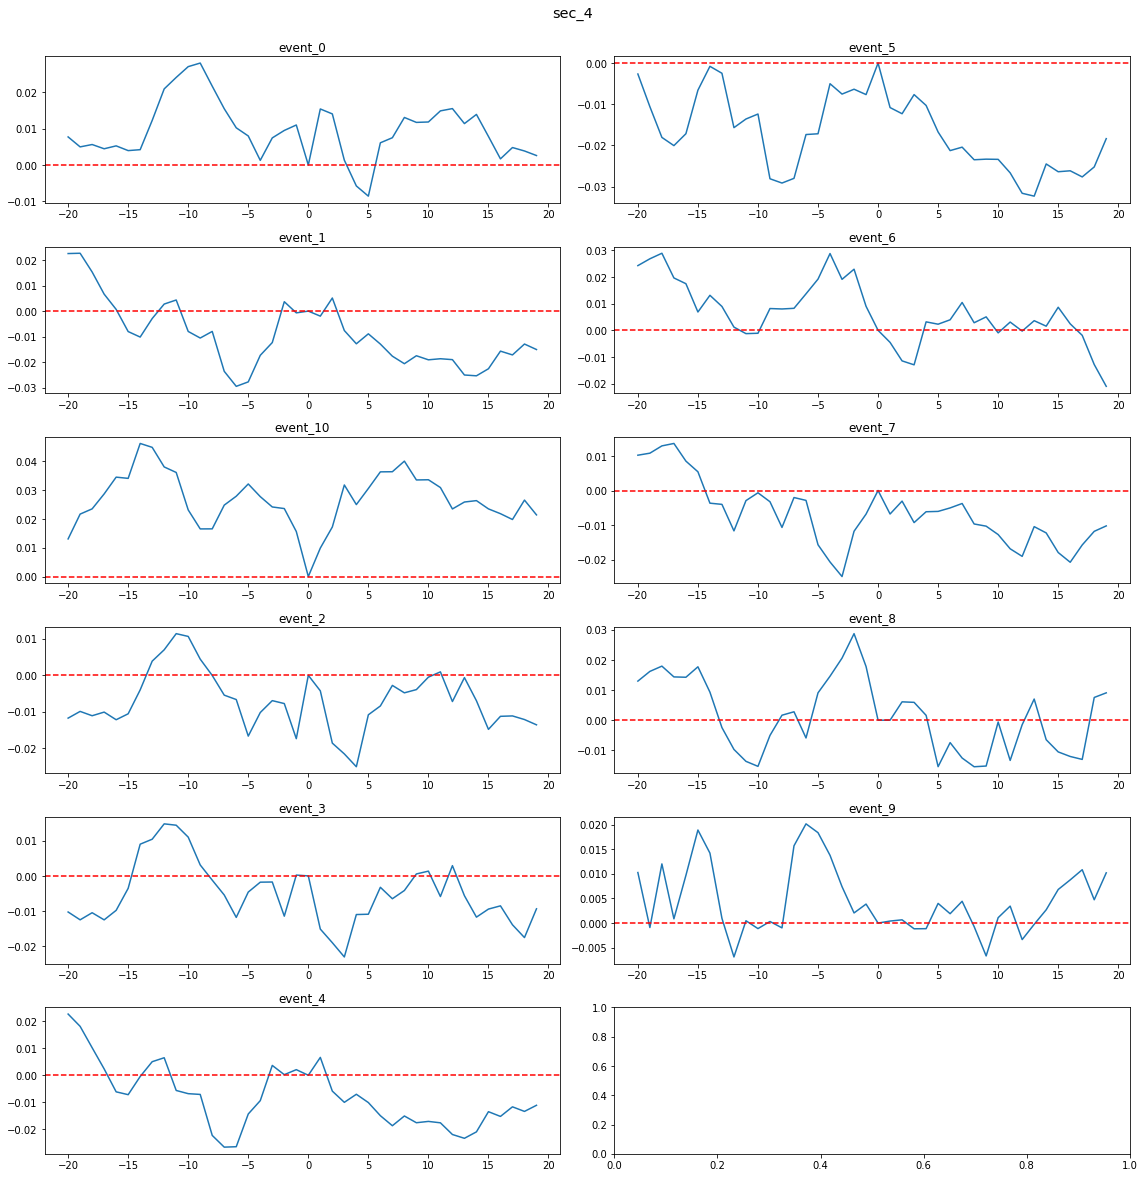

In [40]:
evts=events.set_index('dtidx')
evts=evts[evts.index!=12601]
evts = evts[evts.index <= in_sample_end]
def plot_event_horizons(srs, evts, window_size):
    """
        Plot average price action around events
    
    :param srs: (pd.Series) security prices timeseries
    :param evts: (pd.DataFrame) events series
    :param window_size: (int) size of window to show price action prior to and post event day
    """
    sub_srs = srs.loc[evts.index]
    event_horizon = np.arange(-window_size,window_size)
    event_px_arr = []
    unique_events = evts['eid'].unique()
    nrows = int(np.ceil(len(unique_events)/2))
    
    fig, ax = plt.subplots(figsize=(16,16), nrows=int(nrows), ncols=2)
    for i,eid in enumerate(unique_events):
        col = int(np.floor(i/nrows))
        row = int(i%nrows)
        
        subevts = evts.loc[evts['eid']==eid]
        for offset in event_horizon:
            subevts[offset] = srs.shift(-offset).fillna(method='ffill') - srs
        
        subevts.dropna(how='any', inplace=True)
        ax[row][col].plot(subevts.loc[:, event_horizon].mean())
        ax[row][col].axhline(0, ls='--', c='r')
        ax[row][col].set_title(eid)
        event_px_arr.append(subevts)
    fig.suptitle(srs.name, fontsize='x-large', y=1.02)
    fig.tight_layout()
    plt.show()
    return 

plot_event_horizons(srs, evts, 20)


### Overall, analysis of the autocorrelation plots suggest each event reoccurs approximately monthly (20-22 business days)
### Events 5 and 10 look quite relevant to sec_4
#### sec_4 rates rally into event 10 starting 5 days prior and sell off 8 days afterwards
##### event 7 appears to contain similar information to event 10
#### sec_4 rates sell off into event 5 for starting around 7 days prior and rally 12 days afterwards
##### events 1 and 4 appear to contain similar information about sec_4 as event 5, just shifted a few days prior. This is confirmed by looking at a matrix of event 'indicators' and time series cross-correlation plots. I think we should look at both event 4 and event 5 in the in-sample backtest


event_9     221
event_7     217
event_0     211
event_2     183
event_4     163
event_6     154
event_10    126
event_1     122
event_5     115
event_3     105
event_8      42
Name: eid, dtype: int64


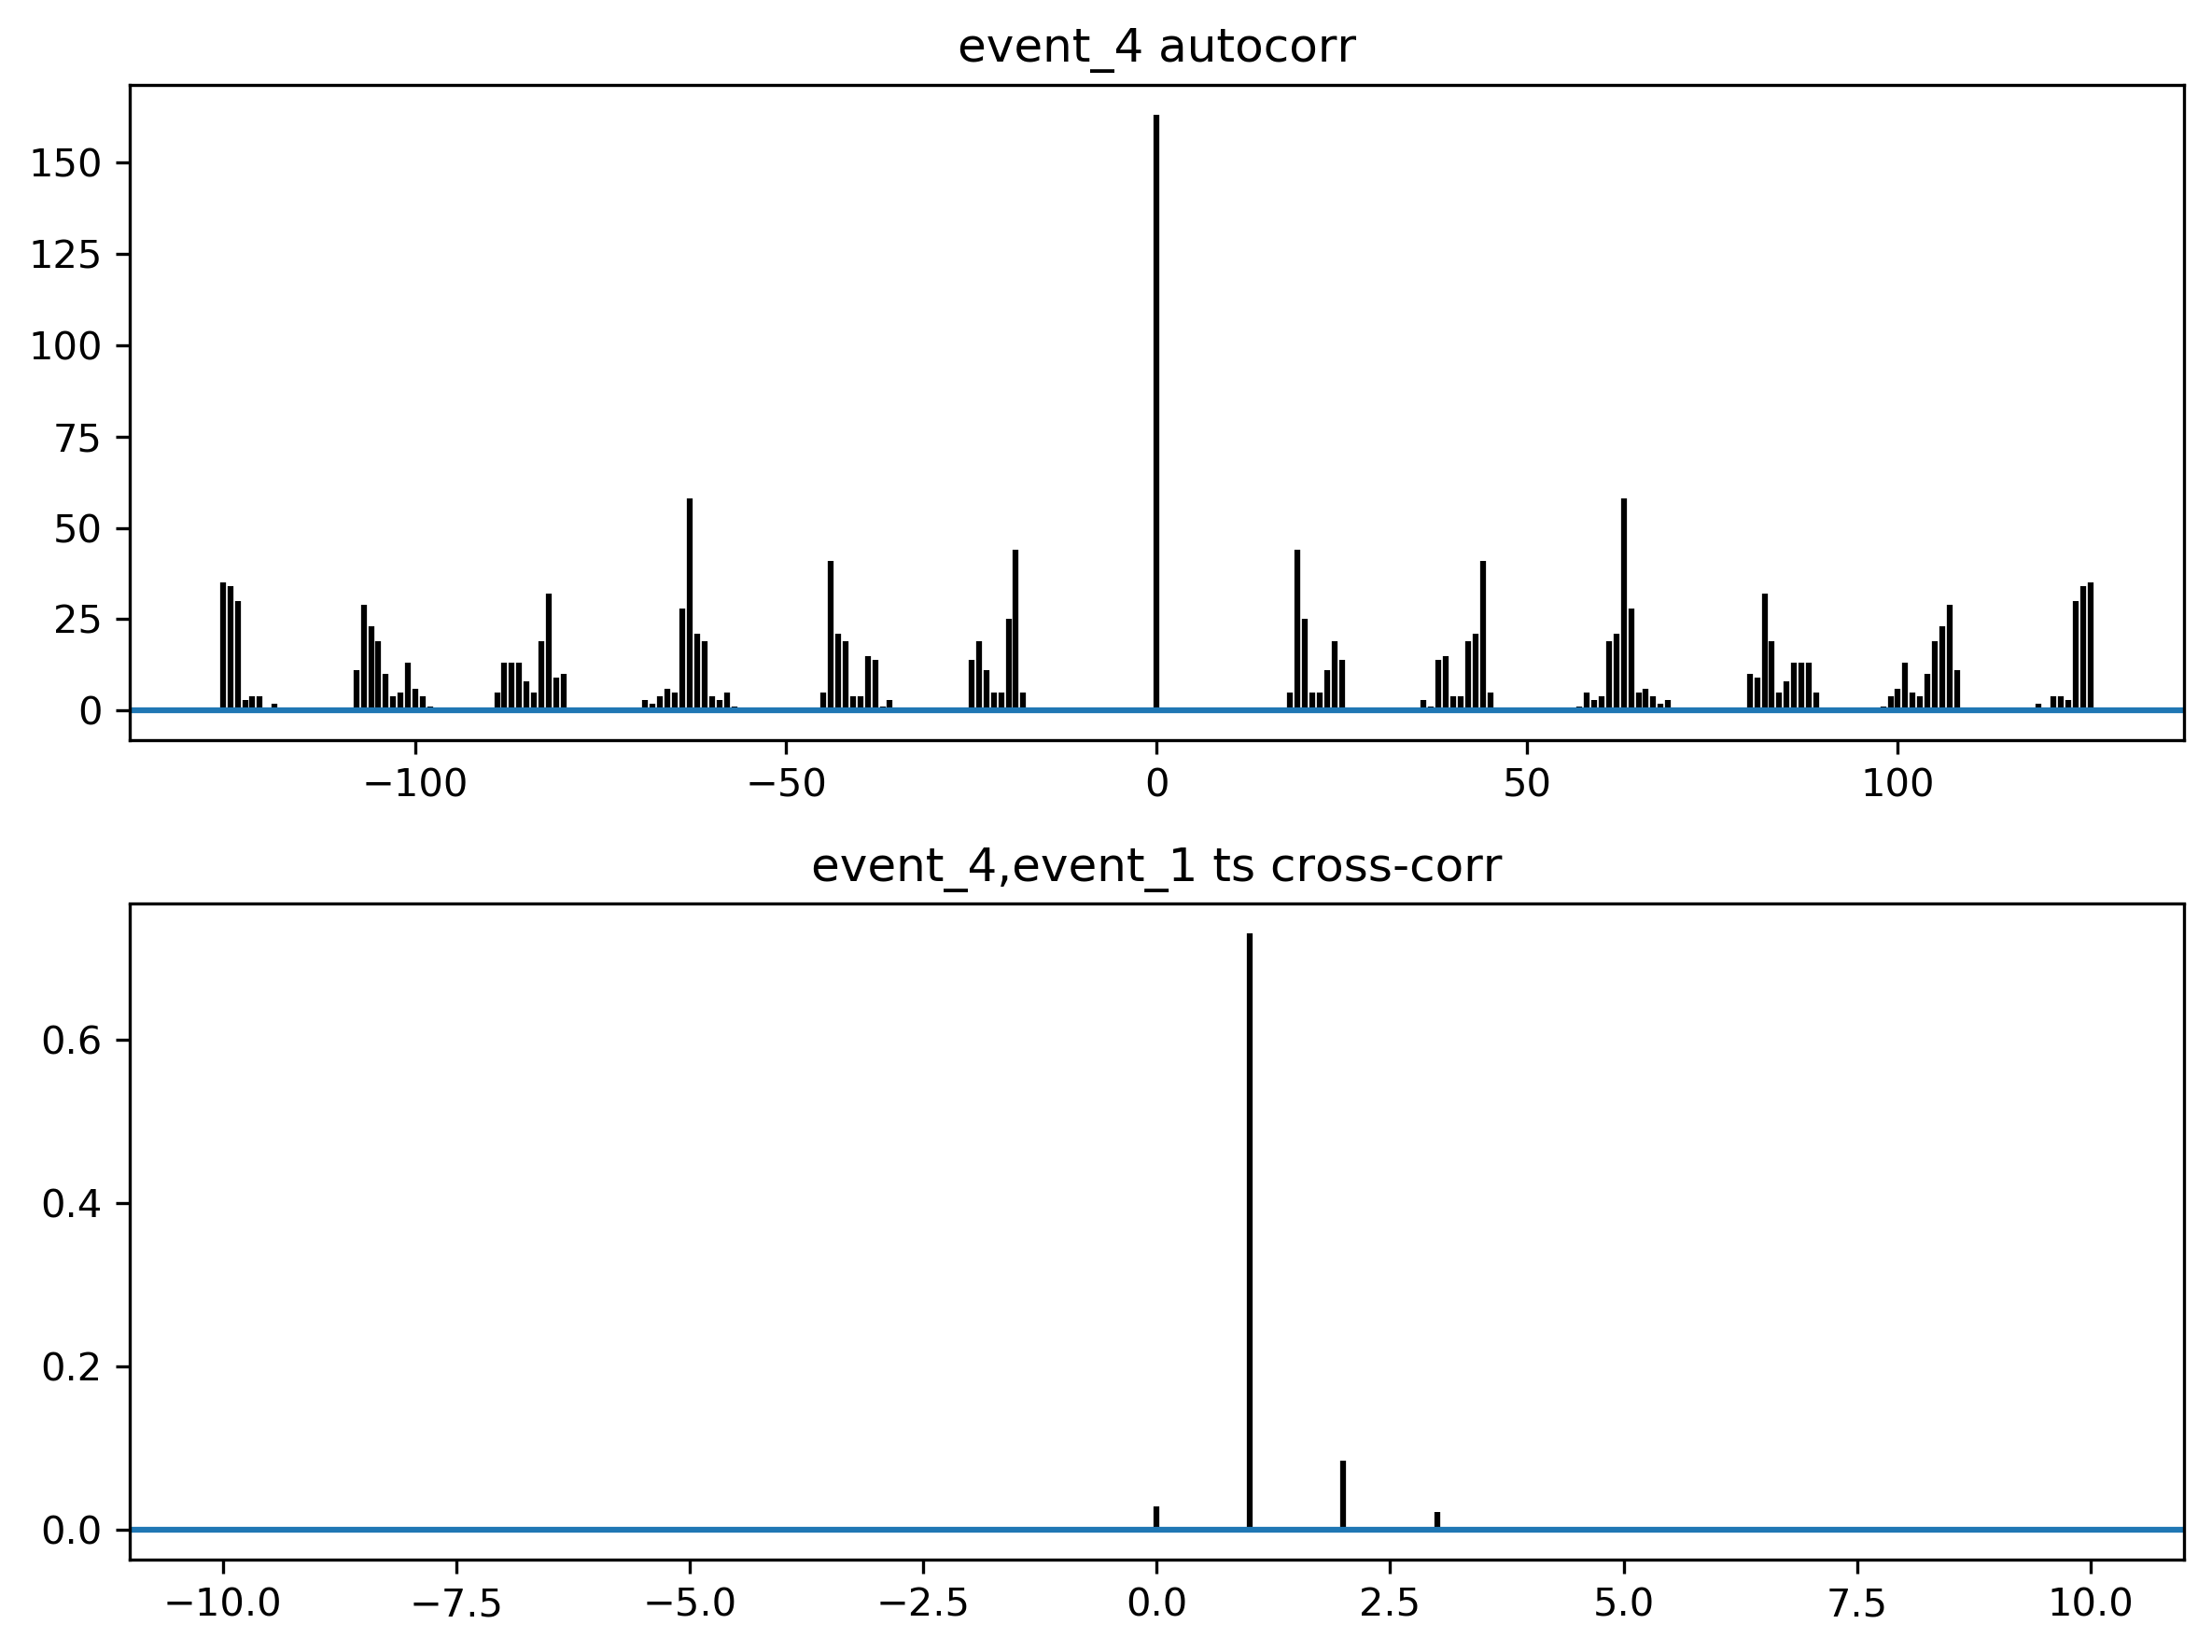

In [46]:
print(evts['eid'].value_counts())
dt_min = evts.index.min()
dt_max = evts.index.max()
evts['ind'] = 1
evts_pvt = evts.pivot_table(index='dtidx',columns='eid')
evts_pvt.columns = evts_pvt.columns.droplevel(0)
everyday = pd.Series(index=pd.Index(np.arange(dt_min, dt_max+1), name='dtidx'),name='everyday')
evts_pvt = evts_pvt.join(everyday, how='outer').fillna(0).drop('everyday', axis=1)

evt1, evt2 = 'event_4','event_1' #events to analyze
fig, ax = plt.subplots(figsize=(8,6), nrows=2, dpi=300)
ax[0].acorr(evts_pvt[evt1], normed=False, maxlags=126)
ax[1].xcorr(evts_pvt[evt1], evts_pvt[evt2])
ax[0].set_title(evt1+' autocorr')
ax[1].set_title(evt1+','+evt2+' ts cross-corr')
fig.tight_layout()
plt.show()

## Question 3: strategy construction and in-sample/out-of-sample evaluation
### Given the above in-sample analysis, we construct a strategy for sec_4 
####    a. Trade the momentum signal: the 60-day lookback, 5 to 20-day holding periods appears to be among the strongest in-sample. We could do something simple akin to our regression study: resample at e.g. 20-day frequencies and take performance averages over the 'ensemble' of each potential starting points $\in [0,19]$. This setup would be more difficult to then overlay on the event-based strategy at lower frequency, so instead we define the simple strategy where our position (${p_t}$) is the average of the daily-generated 'live' signals at time t$^{1,2}$. This gives us max position sizes $\in [-1, 1]$, the case $abs(p_t) < 1$ when we have conflicting 'live' signals.

#### b. Trade the event-based signal: we try 3 strategies to try to profit from the observed patterns around the relevant events: 
     i. In the first we 'buy' 1 unit sec_4 (short duration) 7 days prior to event_4, 'sell' 2 units sec_4 on day of event_4, 
         and buy back remaining 1 unit 12 days .
     ii. In the second we do the same for event_5, as we plan to choose either event_4 or event_5 as they are extremely 
         similar in timing
     iii. In the third we sell 1 unit sec_4 (long duration) 5 days prior to event_10, buy 2 units sec_4 on event_10, sell 1 
         unit 7 days after event_10

 $^{1}$ Jegadeesh, N., Titman, S., 1993. Returns to buying winners and selling losers: implications for stock market efficiency. Journal of Finance 48, 65–91.
 
 $^{2}$ Moskowitz, Tobias J. and Ooi, Yao Hua and Pedersen, Lasse Heje, Time Series Momentum (September 1, 2011). Chicago Booth Research Paper No. 12-21; Fama-Miller Working Paper.

In [50]:
# create signals
in_sample_end = px.index[-int(px.shape[0]/5)] #dtidx of when in-sample period ends
lookbacks = [60] #return frequencies
z_threshold = 0.0 #zscore threshold for signal generation, 0 for simplicity otherwise we have complexities arising from overlaps
zscore_lookback = 120 #rolling window size to generate uncentered zscores
v = 5 #holding period
series_name = 'sec_4'
strategy_desc = "{0}d lookback, {1}d holding, {2}-sigma threshold".format(lookbacks[0], v, z_threshold)
srs = px.loc[:in_sample_end, series_name] #in-sample series to analyze


signals, zscores = gen_mom_signals(srs, z_threshold=z_threshold, lookbacks=lookbacks, zscore_lookback=zscore_lookback)
signal = signals.loc[:, lookbacks[0]].shift(1).dropna() #pnl will assume we can enter position at same close px of signal generation
avg_position, mom_events = get_pat_events(srs, signal, v)


### As can be seen below, this has the effect of 'scaling' us out of positions as the signal flips, which helps mitigate transaction cost induced by constantly flipping positions from a strategy that has a low-threshold for creating a signal

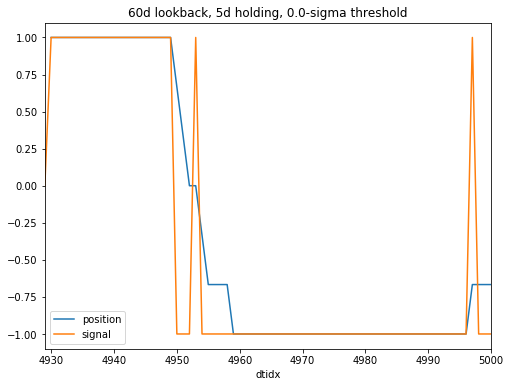

In [51]:
fig, ax = plt.subplots(figsize=(8,6))
avg_position.loc[4929:5000, 'position'].plot(ax=ax)
signal.loc[4929:5000].plot(ax=ax)
ax.legend(['position','signal'])
ax.set_title(strategy_desc)
plt.show()

## Backtest

### a. Momentum
     Constant 1 cent per bp exposure at full size, no transaction cost, ignoring carry for simplicity, to strategy's 
     detriment since it is on average long duration (short the security 'price')

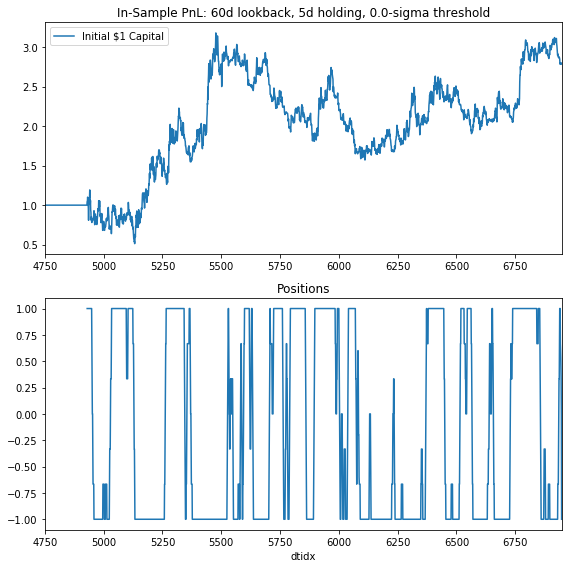

Time Wgtd Avg Position: -0.157
Time Wgtd Gross Position: 0.885
$ Units Below


Ann. Ret.            0.223537
Ann. Vol.            0.766537
IR                   0.291620
Calmar               0.139078
Max Drawdown        -1.607278
# Trades          2011.000000
Avg. Daily PnL       0.000814
dtype: float64

In [52]:
mom_summary, mom_pnl_index = generate_perf_summary(mom_events, srs)
fig, ax = plt.subplots(figsize=(8,8), nrows=2)
mom_pnl_index.plot(ax=ax[0])
ax[0].legend(['Initial $1 Capital'])
ax[0].set_title('In-Sample PnL: '+strategy_desc)
avg_position['position'].plot(ax=ax[1])
ax[1].set_title('Positions')
fig.tight_layout()
plt.show()
print('Time Wgtd Avg Position:', np.round(avg_position['position'].mean(),3))
print('Time Wgtd Gross Position:', np.round(abs(avg_position['position']).mean(),3))
print('$ Units Below')
mom_summary

## Backtest

### b. Event-driven
     Constant 1 cent per bp exposure at max position, no transaction cost, ignoring carry (for simplicity, to the 
     strategy's detriment since we are time-wgtd long duration and curve is on average positive)

In [53]:
def gen_event_driven(evt, px, entry, exit, size=1):
    """
        Generate events dataframe from event-driven strategy
        
    :param evt: (pd.Index) event datestamps
    :param px: (pd.Series) available close prices
    :param prior: (array[2] int) business days prior, side
    :param after: (array[2] int) business days post, side
    :return: (pd.DataFrame) 'events' dataframe: index=entry, t1=timeouts, side, size
    """
    # unpack inputs
    
    # have to shift event 1 day forward because of how we define the pnl series
    # in other words, we want to align our position entered at the close at idx t with the return at t+1 (r_t+1 = r_t+1 - r_t)
    evt = pd.Series(evt+1) 
    days_prior, side_prior = entry
    days_after, side_after = exit
    
    first_date = min(px.index)
    max_date = max(px.index)
    
    evt = evt[((evt-days_prior)>=first_date) & ((evt+days_after)<=max_date)]
    
    first_trade = [[max(e-days_prior, first_date), e, side_prior, size] for e in evt.values]
    second_trade = [[e, min(e+days_after, max_date), side_after, size] for e in evt.values]

    start_trade = pd.DataFrame(first_trade, columns=['dtidx','t1','side','size'])
    event_trade = pd.DataFrame(second_trade, columns=['dtidx','t1','side','size'])

    events = pd.concat([start_trade, event_trade], ignore_index=True, sort=True).set_index('dtidx').sort_index()
    return events

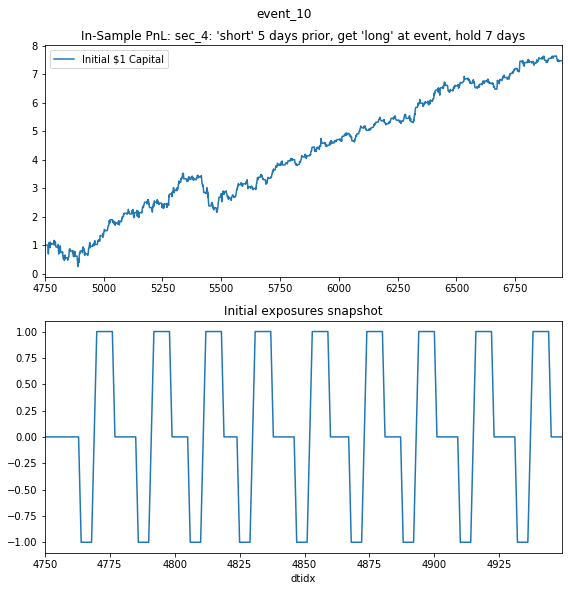

Time Wgtd Avg Position: 0.095
Time Wgtd Avg Gross Position: 0.568
$ Units Below


Ann. Ret.           0.746950
Ann. Vol.           0.693349
IR                  1.077308
Calmar              0.543315
Max Drawdown       -1.374800
# Trades          208.000000
Avg. Daily PnL      0.002944
dtype: float64

In [57]:
this_event = 'event_10'
entry_setting = [5, -1]
event_setting = [7, 1]
event_desc = series_name+': \'short\' 5 days prior, get \'long\' at event, hold 7 days'

event_driven_events = gen_event_driven(evts[evts['eid']==this_event].index, srs, entry_setting, event_setting)
event_summary, event_pnl_index = generate_perf_summary(event_driven_events, srs)
exposures = generate_exposures(event_driven_events, srs)

fig, ax = plt.subplots(figsize=(8,8), nrows=2)
event_pnl_index.plot(ax=ax[0])
ax[0].legend(['Initial $1 Capital'])
ax[0].set_title('In-Sample PnL: '+event_desc)
exposures.iloc[:200].plot(ax=ax[1])
ax[1].set_title('Initial exposures snapshot')
fig.suptitle(this_event,y=1.02)
fig.tight_layout()
plt.show()
print('Time Wgtd Avg Position:', np.round(exposures.mean(),3))
print('Time Wgtd Avg Gross Position:', np.round(abs(exposures).mean(),3))
print('$ Units Below')
event_summary

## Backtest

### Out-of-sample
    We decide to evaluate out-of-sample our best performing strategy parameters chosen over the in-sample period, again
        constant 1 cent per bp risk:
    a. Momentum: 60d lookback (normalized for trailing vol) held for 20d (non-normalized), evaluated daily. Position 
        rebalanced daily to the average 'live' signal on each day
    b. Event-based:
      i. Sec_4: Long the 'price' 7d prior to event_4, sell long and enter short on event day close, cover short 12d after
      ii. Sec_4: Short the 'price' 5d prior to event_10, cover short and enter long on event day close, close long 7d after
    c. Combination: based on the in-sample IRs, size momentum at 1/4, event_4 at 1, event_10 at 1/2

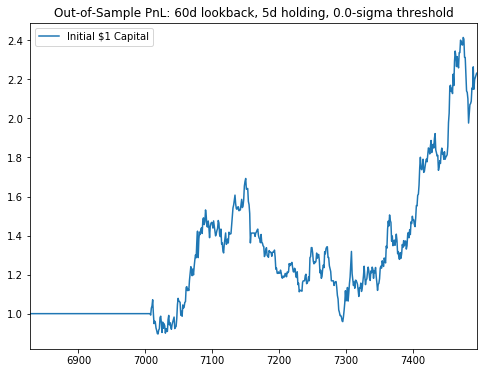

Time Wgtd Avg Position: 0.018
Time Wgtd Gross Position: 0.947
$ Units Below


Ann. Ret.           0.6373
Ann. Vol.           0.5195
IR                  1.2267
Calmar              0.8689
Max Drawdown       -0.7334
# Trades          483.0000
Avg. Daily PnL      0.0018
dtype: float64

In [63]:
zscore_lookback = 120 #rolling window size to generate uncentered zscores
#dtidx of when out-of-sample period starts, we allow for some overlap to calc trailing vol
oos_start = in_sample_end+1-zscore_lookback 
lookbacks = [60] #return frequencies
z_threshold = 0.0 #zscore threshold for signal generation, 0 for simplicity otherwise we have complexities arising from overlaps

v = 5 #holding period
series_name = 'sec_4'
strategy_desc = "{0}d lookback, {1}d holding, {2}-sigma threshold".format(lookbacks[0], v, z_threshold)
srs_oos = px.loc[oos_start:, series_name] #in-sample series to analyze

signals_oos, zscores_oos = gen_mom_signals(srs_oos, z_threshold=z_threshold, lookbacks=lookbacks, zscore_lookback=zscore_lookback)
signal_oos = signals_oos.loc[:, lookbacks[0]].shift(1).dropna() #pnl will assume we can enter position at same close px of signal generation
avg_position_oos, mom_events_oos = get_pat_events(srs_oos, signal_oos, v)

mom_summary_oos, mom_pnl_index_oos = generate_perf_summary(mom_events_oos, srs_oos)
fig, ax = plt.subplots(figsize=(8,6))
mom_pnl_index_oos.plot(ax=ax)
ax.legend(['Initial $1 Capital'])
ax.set_title('Out-of-Sample PnL: '+strategy_desc)
plt.show()
print('Time Wgtd Avg Position:', np.round(avg_position_oos['position'].mean(),3))
print('Time Wgtd Gross Position:', np.round(abs(avg_position_oos['position']).mean(),3))
print('$ Units Below')
mom_summary_oos.round(4)

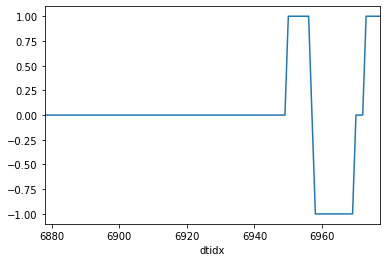

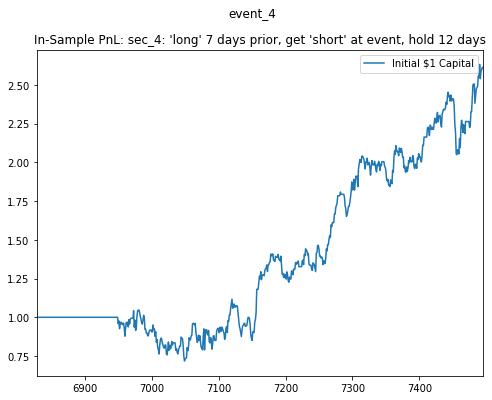

Time Wgtd Avg Position: -0.195
Time Wgtd Avg Gross Position: 0.719
$ Units Below


Ann. Ret.          0.7456
Ann. Vol.          0.5222
IR                 1.4279
Calmar             1.8479
Max Drawdown      -0.4035
# Trades          52.0000
Avg. Daily PnL     0.0024
dtype: float64

In [65]:
this_event = 'event_4'
oos_start = in_sample_end+1
evts_oos=events.set_index('dtidx')
evts_oos=evts_oos[evts_oos.index!=12601]
evts_oos = evts_oos[evts_oos.index >= oos_start]
entry_setting = [7, 1]
event_setting = [12, -1]
event_desc = series_name+': \'long\' 7 days prior, get \'short\' at event, hold 12 days'

event_driven_events_oos = gen_event_driven(evts_oos[evts_oos['eid']==this_event].index, srs_oos, entry_setting, event_setting)
event_summary_oos, event_pnl_index_oos = generate_perf_summary(event_driven_events_oos, srs_oos)

fig, ax = plt.subplots()
exposures_oos = generate_exposures(event_driven_events_oos, srs_oos)
exposures_oos.iloc[50:150].plot(ax=ax)

plt.show()

fig, ax = plt.subplots(figsize=(8,6))
event_pnl_index_oos.plot(ax=ax)
ax.legend(['Initial $1 Capital'])
ax.set_title('In-Sample PnL: '+event_desc)
fig.suptitle(this_event)
plt.show()
print('Time Wgtd Avg Position:', np.round(exposures_oos.mean(),3))
print('Time Wgtd Avg Gross Position:', np.round(abs(exposures_oos).mean(),3))
print('$ Units Below')
event_summary_oos.round(4)

In [60]:
# combine strategies with weights
def generate_comb_perf_summary(pnl_indexes, weights):
    """
    Function to generate CAGR, vol, sharpe, calmar, max drawdown, # trades, avg pnl per trade, hit ratio
    
    :input pnl_indexes: (1d-array) array of series of pnl indexes
    :input weights: (np.array) weights assigned to pnl indexes
    :return: (pd.DataFrame) summary of pnl attributes
    """
    merge_pnl = pd.concat(pnl_indexes, axis=1)
    pnl_index = merge_pnl.dot(weights/sum(weights))
    first_date = min([pnl_index.index[0] for pnl_index in pnl_indexes])
    last_date = max([pnl_index.index[-1] for pnl_index in pnl_indexes])
    years_live = (last_date-first_date)/252
    # since it's constant exposure, use simple average
    #cagr = np.power(pnl_index.iloc[-1]/pnl_index.iloc[0],1/years_live)-1.
    avg_ret = (pnl_index.iloc[-1]/pnl_index.iloc[0]-1)/years_live
    returns = pnl_index.diff(1).dropna()
    vol = returns.std()
    # assumes daily close data
    annualized_vol = vol*np.sqrt(252)
    sharpe = avg_ret/annualized_vol
    drawdown_pnl = pnl_index.subtract(pnl_index.expanding(0).max())
    max_dd = np.min(drawdown_pnl)
    calmar = -avg_ret/max_dd
    
    avg_pnl = pnl_index.diff(1).dropna(0).mean()
    
    summary = pd.Series([avg_ret,annualized_vol,sharpe,calmar, max_dd, avg_pnl], 
                       index=['Ann. Ret.','Ann. Vol.','IR','Calmar','Max Drawdown','Avg. Daily PnL'])
    return summary, pnl_index



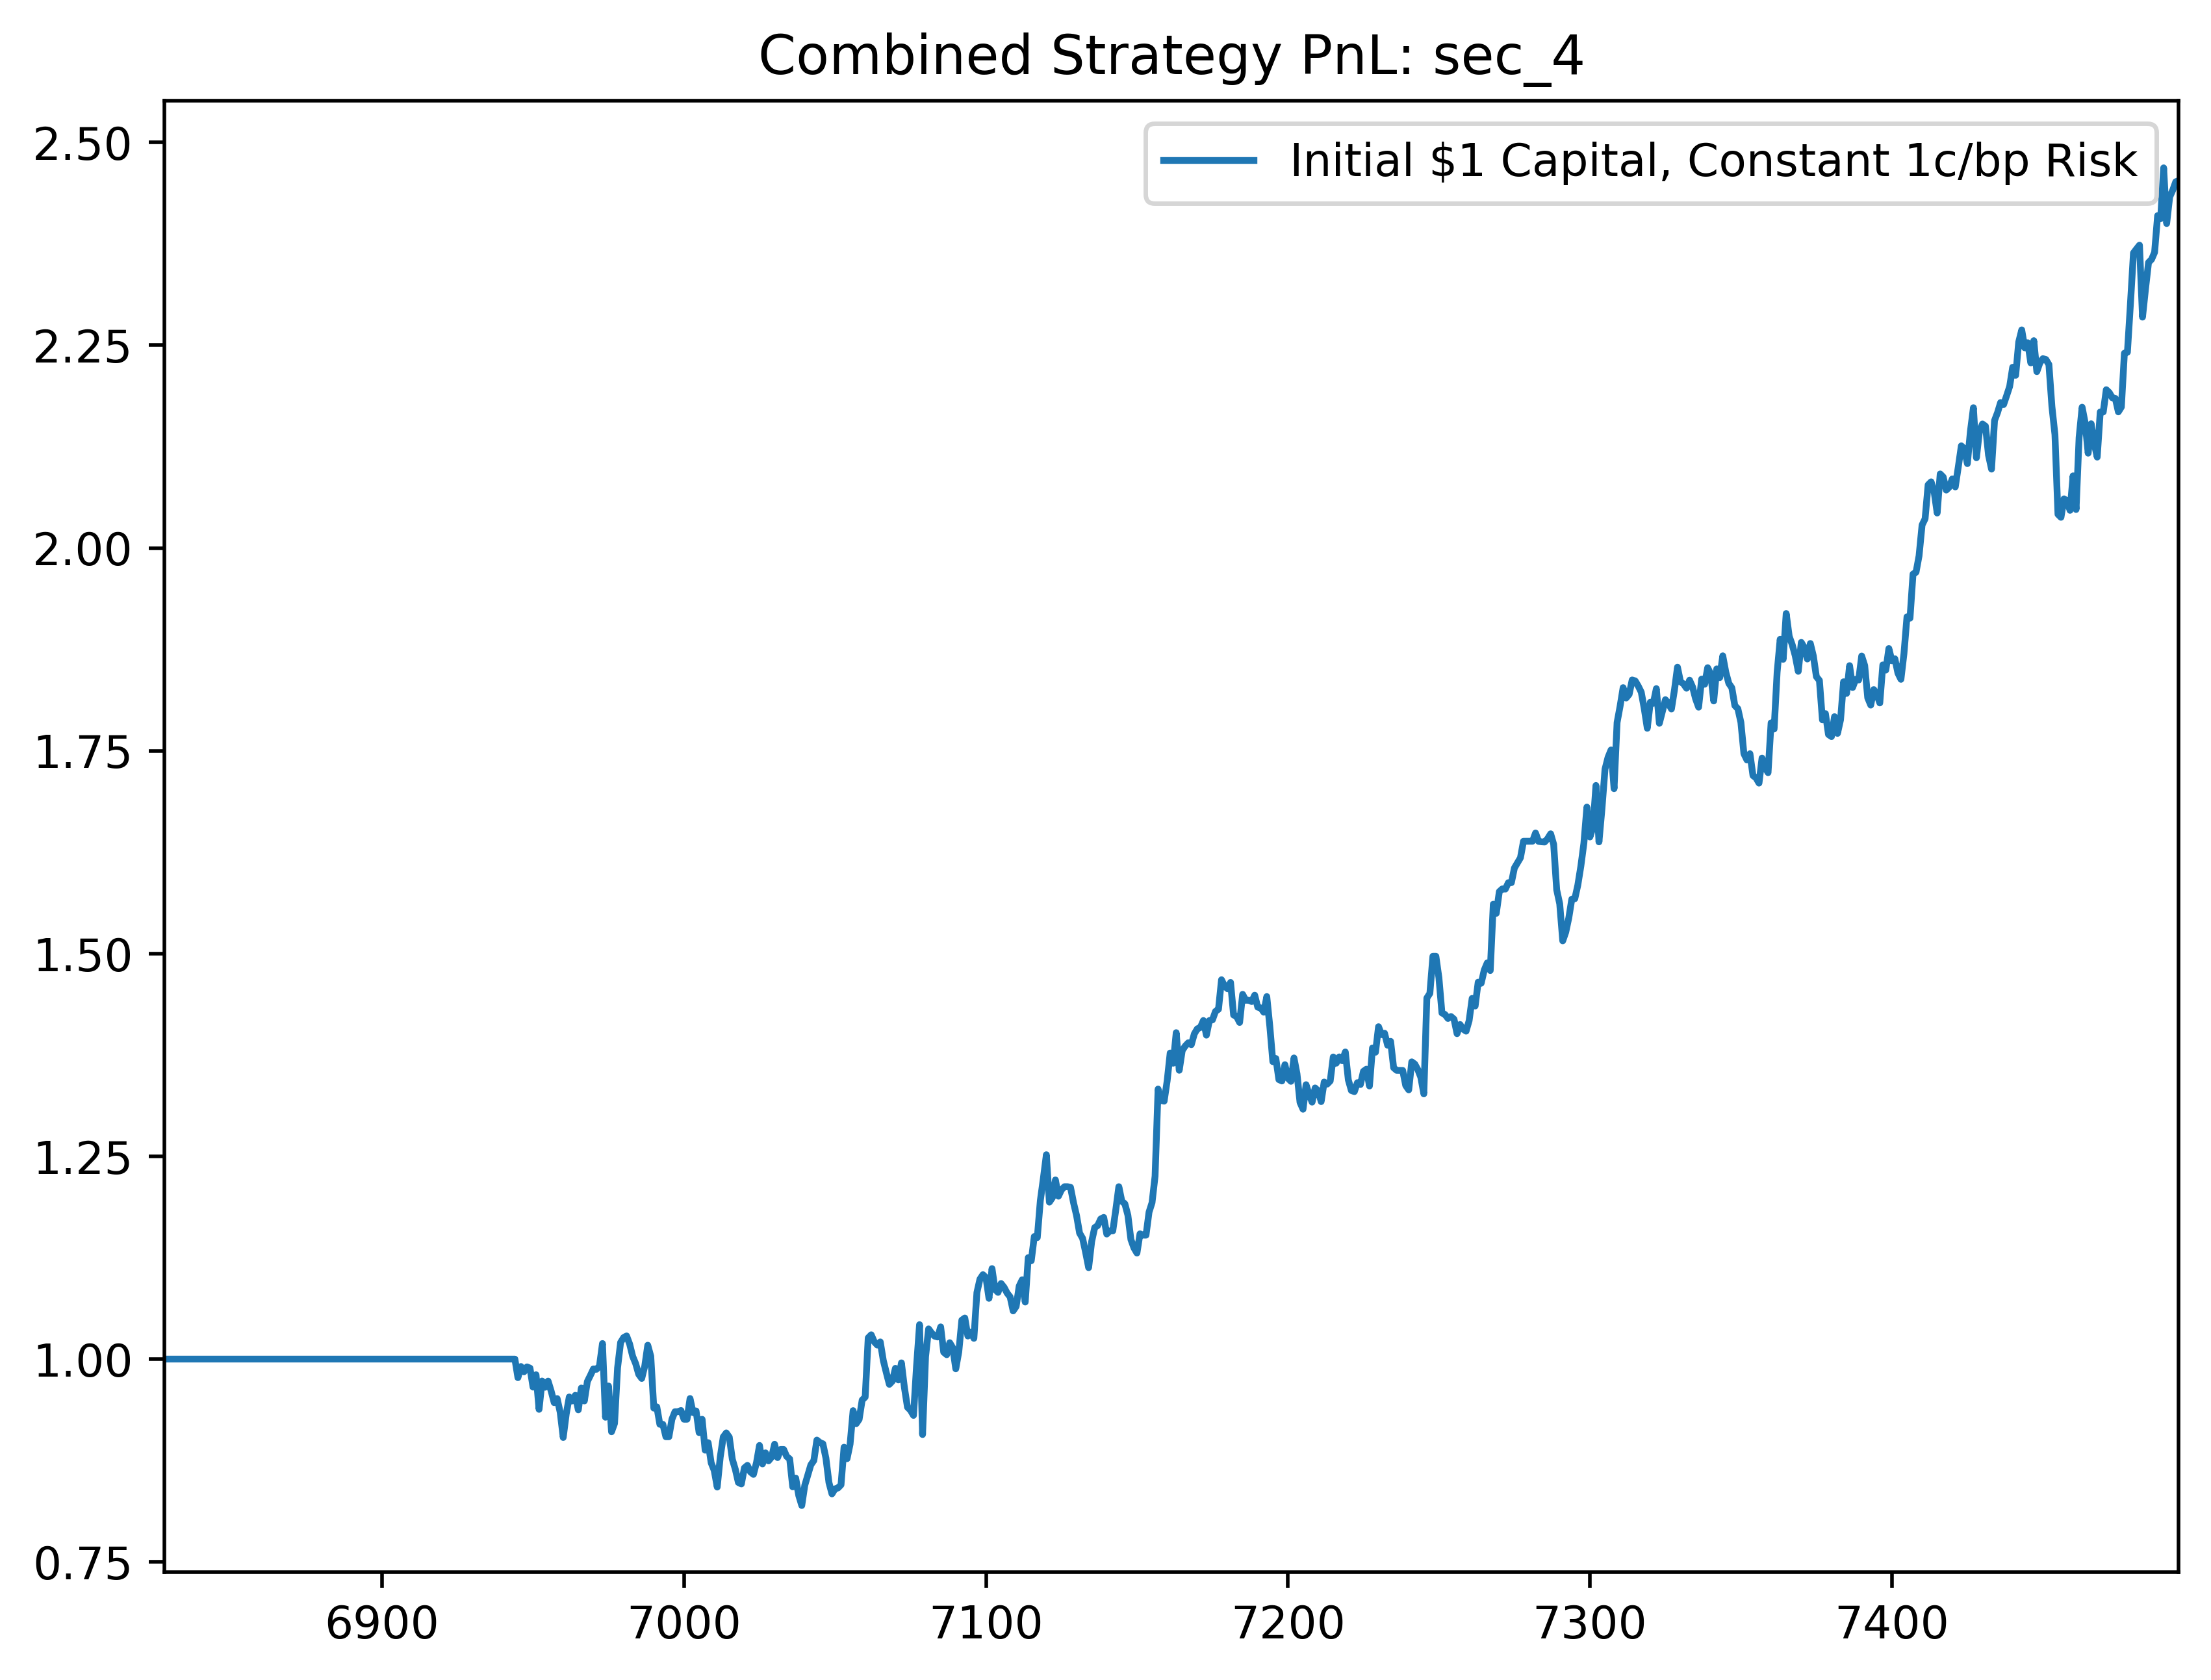

sec_4


Ann. Ret.         0.5490
Ann. Vol.         0.3864
IR                1.4208
Calmar            2.3758
Max Drawdown     -0.2311
Avg. Daily PnL    0.0022
dtype: float64

In [66]:
oos_start = in_sample_end+1
evts_oos=events.set_index('dtidx')
evts_oos=evts_oos[evts_oos.index!=12601]
evts_oos = evts_oos[evts_oos.index >= oos_start]

event_4_oos = gen_event_driven(evts_oos[evts_oos['eid']=='event_4'].index, srs_oos, (7,1), (12,-1))
event_10_oos = gen_event_driven(evts_oos[evts_oos['eid']=='event_10'].index, srs_oos, (5,-1), (7,1))
event_summary_oos_4, event_pnl_index_oos_4 = generate_perf_summary(event_4_oos, srs_oos)
event_summary_oos_10, event_pnl_index_oos_10 = generate_perf_summary(event_10_oos, srs_oos)
strategies_pnl = [mom_pnl_index_oos, event_pnl_index_oos_4, event_pnl_index_oos_10]
weights = np.array([0.25, 1, 0.5])
summary, combined_pnl_index = generate_comb_perf_summary(strategies_pnl, weights)


fig, ax = plt.subplots(figsize=(8,6), dpi=500)
combined_pnl_index.plot(ax=ax)
ax.set_title('Combined Strategy PnL: '+ series_name)
ax.legend(['Initial $1 Capital, Constant 1c/bp Risk'])
plt.show()
print(series_name)
summary.round(4)